In [46]:
# import dependencies
from path import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score
from sklearn.svm import SVR,SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta,datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# imports for database connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func

# import these to view table column headers & rows
from sqlalchemy.orm import sessionmaker
from sqlalchemy import select

import time

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = None

In [47]:
!pwd

/home/sami/education/DataScience/1-UT/capstone/capstone-project-SE-1/capstone-project/regulation/Analysis


In [48]:
class_path = Path("../../classes/pmmfs_ml")

In [49]:
import sys
sys.path.append(class_path)
from ml import ml
# sys.path
m = ml()

In [50]:
engine = create_engine("sqlite:///../Resources/covid_db.db")

In [51]:
# reflect an existing database into a new model (creates base class for automap schema)
Base = automap_base()

In [52]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [53]:
Base.classes.keys()

['covid_stats', 'government_regulation']

In [54]:
# save references to each table
covid_stats = Base.classes.covid_stats
government_regulation = Base.classes.government_regulation

In [55]:
# Create session (link) from Python to the database
session = sessionmaker(bind=engine)()

In [56]:
# View table column headers & rows - covid_stats
covid_stats_table = select('*').select_from(covid_stats)
covid_stats_result = session.execute(covid_stats_table).fetchall()
# print(covid_stats.__table__.columns.keys())
# print(covid_stats_result)

In [57]:
# View table column headers & rows - government_regulation
government_regulation_table = select('*').select_from(government_regulation)
government_regulation_result = session.execute(government_regulation_table).fetchall()
# print(government_regulation.__table__.columns.keys())
# print(government_regulation_result)

In [58]:
# Merge covid_stats_table with government regulation_table
joined = session.query(covid_stats.primary_key_reaction,\
                        covid_stats.date_updated,\
                        covid_stats.iso_code,\
                        covid_stats.continent,\
                        covid_stats.location,\
                        covid_stats.population,\
                        covid_stats.population_density,\
                        covid_stats.median_age,\
                        covid_stats.new_cases,\
                        covid_stats.percentage_of_Pop_New_Cases,\
                        covid_stats.new_deaths,\
                        covid_stats.percentage_of_Pop_New_Deaths,\
                        covid_stats.new_tests,\
                        covid_stats.percentage_of_Pop_New_Tests,\
                        covid_stats.total_cases_updated,\
                        covid_stats.percentage_of_Pop_Total_Cases,\
                        covid_stats.total_deaths_updated,\
                        covid_stats.percentage_of_Pop_Total_Deaths,\
                        covid_stats.total_tests_updated,\
                        covid_stats.percentage_of_Pop_Total_Tests,\
                       government_regulation.primary_key_response,\
                       government_regulation.StringencyIndex_updated,\
                       government_regulation.percentage_change_stringency,\
                       government_regulation.StringencyLegacyIndex_updated,\
                       government_regulation.GovernmentResponseIndex_updated,\
                       government_regulation.percentage_change_GovernmentResponse,\
                       government_regulation.ContainmentHealthIndex_updated,\
                       government_regulation.percentage_change_ContainmentHealth,\
                       government_regulation.EconomicSupportIndex_updated,\
                       government_regulation.percentage_change_EconomicSupport)\
        .join(government_regulation,government_regulation.primary_key_response == covid_stats.primary_key_reaction)

# save the query results as a Pandas DataFrame and set the index
df = pd.DataFrame(joined, columns=['primary_key_reaction',
                                             'date_updated',
                                             'iso_code',
                                             'continent',
                                             'location',
                                             'population',
                                             'population_density',
                                             'median_age',
                                             'new_cases',
                                             'percentage_of_Pop_New_Cases',
                                             'new_deaths',
                                             'percentage_of_Pop_New_Deaths',
                                             'new_tests',
                                             'percentage_of_Pop_New_Tests',
                                             'total_cases_updated',
                                             'percentage_of_Pop_Total_Cases',
                                             'total_deaths_updated',
                                             'percentage_of_Pop_Total_Deaths',
                                             'total_tests_updated',
                                             'percentage_of_Pop_Total_Tests',
                                             'primary_key_response',
                                             'StringencyIndex_updated',
                                             'percentage_change_stringency',
                                             'StringencyLegacyIndex_updated',
                                             'GovernmentResponseIndex_updated',
                                             'percentage_change_GovernmentResponse',
                                             'ContainmentHealthIndex_updated',
                                             'percentage_change_ContainmentHealth',
                                             'EconomicSupportIndex_updated',
                                             'percentage_change_EconomicSupport'
                                             ])

In [59]:
# preview 
df

,primary_key_reaction,date_updated,iso_code,continent,location,population,population_density,median_age,new_cases,percentage_of_Pop_New_Cases,new_deaths,percentage_of_Pop_New_Deaths,new_tests,percentage_of_Pop_New_Tests,total_cases_updated,percentage_of_Pop_Total_Cases,total_deaths_updated,percentage_of_Pop_Total_Deaths,total_tests_updated,percentage_of_Pop_Total_Tests,primary_key_response,StringencyIndex_updated,percentage_change_stringency,StringencyLegacyIndex_updated,GovernmentResponseIndex_updated,percentage_change_GovernmentResponse,ContainmentHealthIndex_updated,percentage_change_ContainmentHealth,EconomicSupportIndex_updated,percentage_change_EconomicSupport
0,ABW2020-03-13,2020-03-13,ABW,North America,Aruba,106766,584.800,41.2,2,0.001873,0,0.000000e+00,0,0.000000,2,0.001873,0,0.000000,0,0.000000,ABW2020-03-13,0.00,0.000000,0.00,2.56,0.000000,3.03,0.000000,0.0,0.0
1,ABW2020-03-19,2020-03-19,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,2,0.001873,0,0.000000,0,0.000000,ABW2020-03-19,33.33,0.000000,42.86,29.49,15.015601,34.85,15.016502,0.0,0.0
2,ABW2020-03-20,2020-03-20,ABW,North America,Aruba,106766,584.800,41.2,2,0.001873,0,0.000000e+00,0,0.000000,4,0.003747,0,0.000000,0,0.000000,ABW2020-03-20,33.33,0.000000,42.86,29.49,0.000000,34.85,0.000000,0.0,0.0
3,ABW2020-03-21,2020-03-21,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,4,0.003747,0,0.000000,0,0.000000,ABW2020-03-21,44.44,33.333333,60.71,37.18,26.076636,43.94,26.083214,0.0,0.0
4,ABW2020-03-22,2020-03-22,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,4,0.003747,0,0.000000,0,0.000000,ABW2020-03-22,44.44,0.000000,60.71,37.18,0.000000,43.94,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32272,ZWE2020-08-27,2020-08-27,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,55,0.000370,13,8.746595e-07,951,0.006398,6251,0.042058,179,0.001204,95721,0.644025,ZWE2020-08-27,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0
32273,ZWE2020-08-28,2020-08-28,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,41,0.000276,10,6.728150e-07,1551,0.010435,6292,0.042334,189,0.001272,97272,0.654461,ZWE2020-08-28,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0
32274,ZWE2020-08-29,2020-08-29,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,96,0.000646,6,4.036890e-07,0,0.000000,6388,0.042979,195,0.001312,97272,0.654461,ZWE2020-08-29,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0
32275,ZWE2020-08-30,2020-08-30,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,18,0.000121,1,6.728150e-08,0,0.000000,6406,0.043101,196,0.001319,97272,0.654461,ZWE2020-08-30,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0


In [61]:
future = ["30","45","60","75"]

iso_codes = df["iso_code"].unique()
iso_dicts = {}
for code in iso_codes:
    iso_dicts[code] = {}
    for day in future:
        date_col = "_".join(["date_updated",day])
        df_iso = df[df["iso_code"]==code][["date_updated","iso_code"]]
        df_iso[date_col] = pd.to_datetime(df_iso["date_updated"]) + timedelta(days=int(day))
        df_iso[date_col] = df_iso[date_col].astype(str)
        
        iso_dicts[code][day] = df_iso
            
    

In [64]:
for day in future:
    cum_df = pd.DataFrame()
    for code in iso_codes:
        cum_df = cum_df.append(iso_dicts[code][day])


In [65]:
df[df["date_updated"]=="2020-03-15"]

,primary_key_reaction,date_updated,iso_code,continent,location,population,population_density,median_age,new_cases,percentage_of_Pop_New_Cases,new_deaths,percentage_of_Pop_New_Deaths,new_tests,percentage_of_Pop_New_Tests,total_cases_updated,percentage_of_Pop_Total_Cases,total_deaths_updated,percentage_of_Pop_Total_Deaths,total_tests_updated,percentage_of_Pop_Total_Tests,primary_key_response,StringencyIndex_updated,percentage_change_stringency,StringencyLegacyIndex_updated,GovernmentResponseIndex_updated,percentage_change_GovernmentResponse,ContainmentHealthIndex_updated,percentage_change_ContainmentHealth,EconomicSupportIndex_updated,percentage_change_EconomicSupport
241,AFG2020-03-15,2020-03-15,AFG,Asia,Afghanistan,38928341,54.422,18.6,3,7.706468e-06,0,0.000000e+00,0,0.000000,10,2.568823e-05,0,0.000000e+00,0,0.000000,AFG2020-03-15,38.89,0.000000,48.81,33.33,0.000000,39.39,0.000000,0.0,0.0
580,ALB2020-03-15,2020-03-15,ALB,Europe,Albania,2877800,104.871,38.0,5,1.737438e-04,0,0.000000e+00,0,0.000000,38,1.320453e-03,1,3.474877e-05,0,0.000000,ALB2020-03-15,81.48,3.532402,88.10,62.82,3.152709,74.24,3.154092,0.0,0.0
824,ARE2020-03-15,2020-03-15,ARE,Asia,United Arab Emirates,9890400,112.442,34.0,1,1.011081e-05,0,0.000000e+00,6616,0.066893,86,8.695300e-04,0,0.000000e+00,90187,0.911864,ARE2020-03-15,34.26,0.000000,46.43,33.97,0.000000,40.15,0.000000,0.0,0.0
1027,ARG2020-03-15,2020-03-15,ARG,South America,Argentina,45195777,16.177,31.9,11,2.433856e-05,0,0.000000e+00,78,0.000173,45,9.956682e-05,2,4.425192e-06,408,0.000903,ARG2020-03-15,25.00,0.000000,30.95,27.56,0.000000,32.58,0.000000,0.0,0.0
1271,AUS2020-03-15,2020-03-15,AUS,Oceania,Australia,25499881,3.202,37.9,52,2.039225e-04,0,0.000000e+00,0,0.000000,249,9.764751e-04,3,1.176476e-05,0,0.000000,AUS2020-03-15,19.44,0.000000,25.00,25.64,0.000000,28.03,0.000000,12.5,0.0
1515,AUT2020-03-15,2020-03-15,AUT,Europe,Austria,9006400,106.749,44.4,151,1.676586e-03,0,0.000000e+00,700,0.007772,655,7.272606e-03,1,1.110322e-05,8167,0.090680,AUT2020-03-15,48.15,0.000000,65.48,39.74,0.000000,46.97,0.000000,0.0,0.0
1759,AZE2020-03-15,2020-03-15,AZE,Asia,Azerbaijan,10139175,119.309,32.4,6,5.917641e-05,0,0.000000e+00,0,0.000000,19,1.873920e-04,0,0.000000e+00,0,0.000000,AZE2020-03-15,52.78,0.000000,53.57,49.36,0.000000,58.33,0.000000,0.0,0.0
2156,BEL2020-03-15,2020-03-15,BEL,Europe,Belgium,11589616,375.564,41.8,179,1.544486e-03,5,4.314207e-07,1269,0.010949,1542,1.330501e-02,13,1.121694e-04,14412,0.124353,BEL2020-03-15,50.93,0.000000,67.86,51.28,0.000000,49.24,0.000000,62.5,0.0
2496,BFA2020-03-15,2020-03-15,BFA,Africa,Burkina Faso,20903278,70.151,17.6,1,4.783939e-06,0,0.000000e+00,0,0.000000,3,1.435182e-05,0,0.000000e+00,0,0.000000,BFA2020-03-15,11.11,0.000000,14.29,17.95,0.000000,21.21,0.000000,0.0,0.0
2677,BGD2020-03-15,2020-03-15,BGD,Asia,Bangladesh,164689383,1265.036,27.5,0,0.000000e+00,0,0.000000e+00,27,0.000016,3,1.821611e-06,0,0.000000e+00,268,0.000163,BGD2020-03-15,13.89,0.000000,17.86,18.59,0.000000,21.97,0.000000,0.0,0.0


In [66]:

days = []

for day in future:
    cum_df = pd.DataFrame()
    for code in iso_codes:
        cum_df = cum_df.append(iso_dicts[code][day])

    
    days.append(cum_df.reset_index(drop=True)) 
    
    
len(days)

4

In [67]:
for i,day in enumerate(future):
    days[i] = days[i].merge(df,left_on=["date_updated_" + day,"iso_code"],right_on=["date_updated","iso_code"],how="left",suffixes=["","_"+day])
    days[i] = days[i].reset_index(drop=True)
    date_i = days[i][["date_updated_" + day]]
    date_i = date_i.iloc[:,0]
    days[i].drop(columns=["date_updated_" + day],inplace=True)
    days[i]["date_updated_" + day] = date_i
    days[i] = days[i][["date_updated","iso_code","date_updated_" + day,"total_cases_updated","total_deaths_updated"]]
    days[i].rename(columns={"total_cases_updated":"total_cases_updated_" + day,
                        "total_deaths_updated":"total_deaths_updated_" + day},inplace=True)

In [68]:
days[0][days[0]["iso_code"]=="CAN"]

,date_updated,iso_code,date_updated_30,total_cases_updated_30,total_deaths_updated_30
5099,2020-01-01,CAN,2020-01-31,3.0,0.0
5100,2020-01-02,CAN,2020-02-01,4.0,0.0
5101,2020-01-03,CAN,2020-02-02,4.0,0.0
5102,2020-01-04,CAN,2020-02-03,4.0,0.0
5103,2020-01-05,CAN,2020-02-04,4.0,0.0
5104,2020-01-06,CAN,2020-02-05,5.0,0.0
5105,2020-01-07,CAN,2020-02-06,5.0,0.0
5106,2020-01-08,CAN,2020-02-07,7.0,0.0
5107,2020-01-09,CAN,2020-02-08,7.0,0.0
5108,2020-01-10,CAN,2020-02-09,7.0,0.0


In [69]:
days[0].head()

,date_updated,iso_code,date_updated_30,total_cases_updated_30,total_deaths_updated_30
0,2020-03-13,ABW,2020-04-12,92.0,0.0
1,2020-03-19,ABW,2020-04-18,96.0,2.0
2,2020-03-20,ABW,2020-04-19,96.0,2.0
3,2020-03-21,ABW,2020-04-20,97.0,2.0
4,2020-03-22,ABW,2020-04-21,97.0,2.0


In [70]:
final_df = df
for i in range(len(days)):
    suffix_right = "_" + str(i * 15 + 30)

    final_df = final_df.merge(days[i],on=["date_updated","iso_code"],how="left",suffixes=["",suffix_right]) # 
    

## DF New Deaths

## Predicting Number of New Deaths- with NN Model


# Deep Neural Network



 Training and testing - 30 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 18)                126       
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


813/813 [==============================] - 2s 3ms/step - loss: 0.2400 - mse: 0.2400
Epoch 2/100
813/813 [==============================] - 3s 3ms/step - loss: 0.0374 - mse: 0.0374
Epoch 3/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0305 - mse: 0.0305
Epoch 4/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0272 - mse: 0.0272
Epoch 5/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0234 - mse: 0.0234
Epoch 6/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0216 - mse: 0.0216
Epoch 7/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0210 - mse: 0.0210
Epoch 8/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0180 - mse: 0.0180
Epoch 9/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0186 - mse: 0.0186
Epoch 10/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0171 - mse: 0.0171
Epoch 11/100
813/813 [=============================

813/813 [==============================] - 2s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 86/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 87/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0036 - mse: 0.0036
Epoch 88/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 89/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 90/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 91/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 92/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 93/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 94/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 95/100
813/813 [=====================

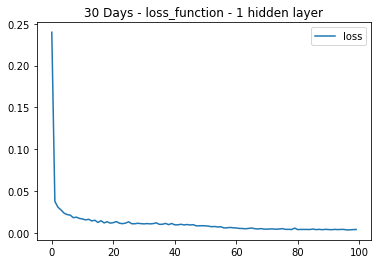

0.9963744518151108
0.9962752128524225


 Training and testing - 45 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 18)                126       
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
_____________________________________________________________

../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


740/740 [==============================] - 2s 3ms/step - loss: 0.2283 - mse: 0.2283
Epoch 2/100
740/740 [==============================] - 2s 2ms/step - loss: 0.1000 - mse: 0.1000
Epoch 3/100
740/740 [==============================] - 2s 2ms/step - loss: 0.0756 - mse: 0.0756
Epoch 4/100
740/740 [==============================] - 2s 2ms/step - loss: 0.0606 - mse: 0.0606
Epoch 5/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0511 - mse: 0.0511
Epoch 6/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0452 - mse: 0.0452
Epoch 7/100
740/740 [==============================] - 2s 2ms/step - loss: 0.0407 - mse: 0.0407
Epoch 8/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0382 - mse: 0.0382
Epoch 9/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0360 - mse: 0.0360
Epoch 10/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0324 - mse: 0.0324
Epoch 11/100
740/740 [=============================

740/740 [==============================] - 2s 3ms/step - loss: 0.0148 - mse: 0.0148
Epoch 86/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0154 - mse: 0.0154
Epoch 87/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0144 - mse: 0.0144
Epoch 88/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0147 - mse: 0.0147
Epoch 89/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0148 - mse: 0.0148
Epoch 90/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0146 - mse: 0.0146
Epoch 91/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0143 - mse: 0.0143
Epoch 92/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0149 - mse: 0.0149
Epoch 93/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0150 - mse: 0.0150
Epoch 94/100
740/740 [==============================] - 3s 4ms/step - loss: 0.0144 - mse: 0.0144
Epoch 95/100
740/740 [=====================

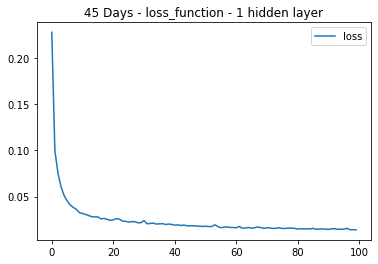

0.9853068267391901
0.9916098852365285


 Training and testing - 60 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
_____________________________________________________________

../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


668/668 [==============================] - 2s 3ms/step - loss: 0.9133 - mse: 0.9133
Epoch 2/100
668/668 [==============================] - 2s 3ms/step - loss: 0.8023 - mse: 0.8023
Epoch 3/100
668/668 [==============================] - 2s 3ms/step - loss: 0.7240 - mse: 0.7240
Epoch 4/100
668/668 [==============================] - 2s 2ms/step - loss: 0.6560 - mse: 0.6560
Epoch 5/100
668/668 [==============================] - 2s 4ms/step - loss: 0.5970 - mse: 0.5970
Epoch 6/100
668/668 [==============================] - 2s 4ms/step - loss: 0.5450 - mse: 0.5450
Epoch 7/100
668/668 [==============================] - 3s 4ms/step - loss: 0.5027 - mse: 0.5027
Epoch 8/100
668/668 [==============================] - 2s 3ms/step - loss: 0.4663 - mse: 0.4663
Epoch 9/100
668/668 [==============================] - 2s 3ms/step - loss: 0.4359 - mse: 0.4359
Epoch 10/100
668/668 [==============================] - 2s 3ms/step - loss: 0.4068 - mse: 0.4068
Epoch 11/100
668/668 [=============================

668/668 [==============================] - 2s 3ms/step - loss: 0.0242 - mse: 0.0242
Epoch 86/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0224 - mse: 0.0224
Epoch 87/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0226 - mse: 0.0226
Epoch 88/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0230 - mse: 0.0230
Epoch 89/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0224 - mse: 0.0224
Epoch 90/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0212 - mse: 0.0212
Epoch 91/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0217 - mse: 0.0217
Epoch 92/100
668/668 [==============================] - 2s 4ms/step - loss: 0.0211 - mse: 0.0211
Epoch 93/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0217 - mse: 0.0217
Epoch 94/100
668/668 [==============================] - 3s 4ms/step - loss: 0.0214 - mse: 0.0214
Epoch 95/100
668/668 [=====================

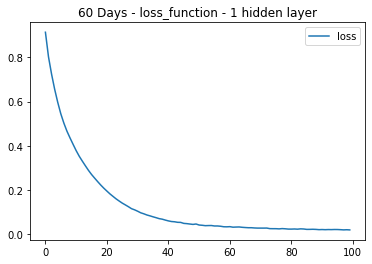

0.971673192568375
0.9549083655949632


 Training and testing - 75 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
______________________________________________________________

../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


Epoch 1/100
595/595 [==============================] - 2s 3ms/step - loss: 0.9247 - mse: 0.9247
Epoch 2/100
595/595 [==============================] - 2s 4ms/step - loss: 0.8201 - mse: 0.8201
Epoch 3/100
595/595 [==============================] - 2s 4ms/step - loss: 0.7443 - mse: 0.7443
Epoch 4/100
595/595 [==============================] - 2s 3ms/step - loss: 0.6851 - mse: 0.6851
Epoch 5/100
595/595 [==============================] - 2s 3ms/step - loss: 0.6380 - mse: 0.6380
Epoch 6/100
595/595 [==============================] - 2s 3ms/step - loss: 0.5989 - mse: 0.5989
Epoch 7/100
595/595 [==============================] - 2s 3ms/step - loss: 0.3913 - mse: 0.3913
Epoch 8/100
595/595 [==============================] - 2s 3ms/step - loss: 0.1940 - mse: 0.1940
Epoch 9/100
595/595 [==============================] - 2s 3ms/step - loss: 0.1702 - mse: 0.1702
Epoch 10/100
595/595 [==============================] - 2s 3ms/step - loss: 0.1521 - mse: 0.1521
Epoch 11/100
595/595 [=================

595/595 [==============================] - 1s 3ms/step - loss: 0.0182 - mse: 0.0182
Epoch 86/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0167 - mse: 0.0167
Epoch 87/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0172 - mse: 0.0172
Epoch 88/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0157 - mse: 0.0157
Epoch 89/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0163 - mse: 0.0163
Epoch 90/100
595/595 [==============================] - 1s 2ms/step - loss: 0.0205 - mse: 0.0205
Epoch 91/100
595/595 [==============================] - 1s 2ms/step - loss: 0.0168 - mse: 0.0168
Epoch 92/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0159 - mse: 0.0159
Epoch 93/100
595/595 [==============================] - 2s 4ms/step - loss: 0.0172 - mse: 0.0172
Epoch 94/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0160 - mse: 0.0160
Epoch 95/100
595/595 [=====================

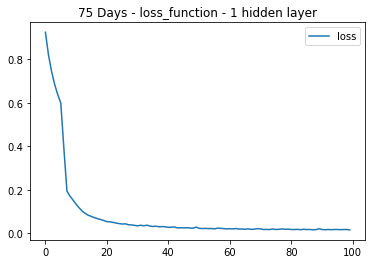

0.986924107045864
0.9849413463924849


In [72]:
layers = { "number_input_features": 6,
      "n_layers": 4, 
      "l0":{"number_hidden_nodes":18,"activation_function":"relu"},
      "l1":{"number_hidden_nodes":9,"activation_function":"relu"},
      "l2":{"number_hidden_nodes":4,"activation_function":"relu"},
      "l3":{"number_hidden_nodes":1,"activation_function":"linear"}
          
     }

md = ml()
md.train_test(df=final_df,test_size=0.05,target="deaths",**layers)
model_d = md.getModel()

## Cases



 Training and testing - 30 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_21 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


813/813 [==============================] - 2s 3ms/step - loss: 0.0558 - mse: 0.0558
Epoch 2/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0178 - mse: 0.0178
Epoch 3/100
813/813 [==============================] - 3s 3ms/step - loss: 0.0150 - mse: 0.0150
Epoch 4/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0127 - mse: 0.0127
Epoch 5/100
813/813 [==============================] - 3s 3ms/step - loss: 0.0108 - mse: 0.0108
Epoch 6/100
813/813 [==============================] - 3s 4ms/step - loss: 0.0092 - mse: 0.0092
Epoch 7/100
813/813 [==============================] - 4s 4ms/step - loss: 0.0089 - mse: 0.0089
Epoch 8/100
813/813 [==============================] - 3s 3ms/step - loss: 0.0079 - mse: 0.0079
Epoch 9/100
813/813 [==============================] - 3s 4ms/step - loss: 0.0079 - mse: 0.0079A: 0s - loss: 0.0079 - ms
Epoch 10/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 11/100
813/813 [====

813/813 [==============================] - 2s 3ms/step - loss: 0.0014 - mse: 0.0014
Epoch 86/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 87/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 88/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 89/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0015 - mse: 0.0015
Epoch 90/100
813/813 [==============================] - 2s 2ms/step - loss: 0.0017 - mse: 0.0017
Epoch 91/100
813/813 [==============================] - 3s 3ms/step - loss: 0.0023 - mse: 0.0023
Epoch 92/100
813/813 [==============================] - 3s 4ms/step - loss: 0.0014 - mse: 0.0014
Epoch 93/100
813/813 [==============================] - 3s 4ms/step - loss: 0.0019 - mse: 0.0019
Epoch 94/100
813/813 [==============================] - 2s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 95/100
813/813 [=====================

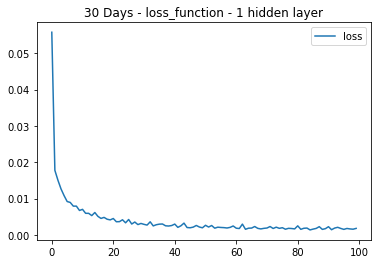

0.9986874487452619
0.997076176091499


 Training and testing - 45 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_25 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
______________________________________________________________

../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


740/740 [==============================] - 2s 2ms/step - loss: 0.9420 - mse: 0.9420
Epoch 2/100
740/740 [==============================] - 2s 3ms/step - loss: 0.8494 - mse: 0.8494
Epoch 3/100
740/740 [==============================] - 3s 4ms/step - loss: 0.7914 - mse: 0.7914
Epoch 4/100
740/740 [==============================] - 2s 2ms/step - loss: 0.7402 - mse: 0.7402
Epoch 5/100
740/740 [==============================] - 2s 3ms/step - loss: 0.6935 - mse: 0.6935
Epoch 6/100
740/740 [==============================] - 2s 2ms/step - loss: 0.6491 - mse: 0.6491
Epoch 7/100
740/740 [==============================] - 2s 2ms/step - loss: 0.6090 - mse: 0.6090
Epoch 8/100
740/740 [==============================] - 2s 2ms/step - loss: 0.5726 - mse: 0.5726
Epoch 9/100
740/740 [==============================] - 2s 2ms/step - loss: 0.5388 - mse: 0.5388
Epoch 10/100
740/740 [==============================] - 2s 2ms/step - loss: 0.5063 - mse: 0.5063
Epoch 11/100
740/740 [=============================

740/740 [==============================] - 2s 2ms/step - loss: 0.0200 - mse: 0.0200
Epoch 86/100
740/740 [==============================] - 2s 2ms/step - loss: 0.0186 - mse: 0.0186
Epoch 87/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0196 - mse: 0.0196
Epoch 88/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0176 - mse: 0.0176
Epoch 89/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0171 - mse: 0.0171
Epoch 90/100
740/740 [==============================] - 3s 4ms/step - loss: 0.0163 - mse: 0.0163
Epoch 91/100
740/740 [==============================] - 2s 2ms/step - loss: 0.0161 - mse: 0.0161
Epoch 92/100
740/740 [==============================] - 2s 2ms/step - loss: 0.0171 - mse: 0.0171
Epoch 93/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0160 - mse: 0.0160
Epoch 94/100
740/740 [==============================] - 2s 3ms/step - loss: 0.0144 - mse: 0.0144
Epoch 95/100
740/740 [=====================

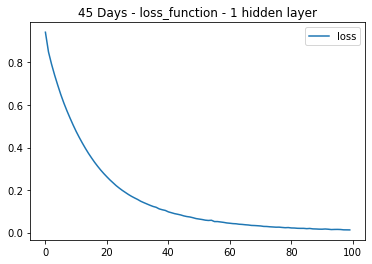

0.9882514835880596
0.9930447656326687


 Training and testing - 60 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_29 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
_____________________________________________________________

../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


668/668 [==============================] - 2s 3ms/step - loss: 1.2053 - mse: 1.2053
Epoch 2/100
668/668 [==============================] - 1s 2ms/step - loss: 0.8858 - mse: 0.8858
Epoch 3/100
668/668 [==============================] - 2s 3ms/step - loss: 0.8292 - mse: 0.8292
Epoch 4/100
668/668 [==============================] - 2s 3ms/step - loss: 0.7871 - mse: 0.7871
Epoch 5/100
668/668 [==============================] - 2s 2ms/step - loss: 0.7452 - mse: 0.7452
Epoch 6/100
668/668 [==============================] - 2s 3ms/step - loss: 0.7068 - mse: 0.7068
Epoch 7/100
668/668 [==============================] - 1s 2ms/step - loss: 0.6680 - mse: 0.6680
Epoch 8/100
668/668 [==============================] - 2s 3ms/step - loss: 0.6305 - mse: 0.6305
Epoch 9/100
668/668 [==============================] - 2s 3ms/step - loss: 0.5933 - mse: 0.5933
Epoch 10/100
668/668 [==============================] - 2s 2ms/step - loss: 0.5598 - mse: 0.5598
Epoch 11/100
668/668 [=============================

668/668 [==============================] - 2s 2ms/step - loss: 0.0251 - mse: 0.0251
Epoch 86/100
668/668 [==============================] - 2s 2ms/step - loss: 0.0240 - mse: 0.0240
Epoch 87/100
668/668 [==============================] - 2s 4ms/step - loss: 0.0243 - mse: 0.0243
Epoch 88/100
668/668 [==============================] - 3s 5ms/step - loss: 0.0229 - mse: 0.0229
Epoch 89/100
668/668 [==============================] - 2s 2ms/step - loss: 0.0214 - mse: 0.0214
Epoch 90/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0245 - mse: 0.0245
Epoch 91/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0232 - mse: 0.0232
Epoch 92/100
668/668 [==============================] - 1s 2ms/step - loss: 0.0204 - mse: 0.0204
Epoch 93/100
668/668 [==============================] - 1s 2ms/step - loss: 0.0203 - mse: 0.0203
Epoch 94/100
668/668 [==============================] - 2s 2ms/step - loss: 0.0196 - mse: 0.0196
Epoch 95/100
668/668 [=====================

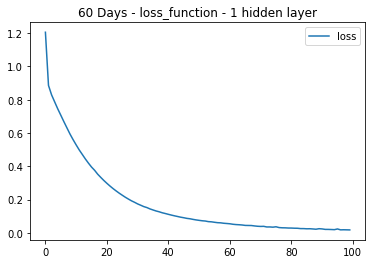

0.9842598232206979
0.9923520844490706


 Training and testing - 75 days ahead


X COLUMNS: Index(['population', 'population_density', 'median_age',
       'StringencyIndex_updated', 'total_cases_updated',
       'total_deaths_updated'],
      dtype='object')
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 18)                126       
_________________________________________________________________
dense_33 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 342
Trainable params: 342
Non-trainable params: 0
_____________________________________________________________

../../classes/pmmfs_ml/ml.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_cases = "_".join(['total_cases_updated',n])


Epoch 1/100
595/595 [==============================] - 2s 3ms/step - loss: 0.5391 - mse: 0.5391
Epoch 2/100
595/595 [==============================] - 2s 3ms/step - loss: 0.1712 - mse: 0.1712
Epoch 3/100
595/595 [==============================] - 3s 4ms/step - loss: 0.1396 - mse: 0.1396
Epoch 4/100
595/595 [==============================] - 2s 3ms/step - loss: 0.1113 - mse: 0.1113
Epoch 5/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0823 - mse: 0.0823
Epoch 6/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0650 - mse: 0.0650
Epoch 7/100
595/595 [==============================] - 1s 2ms/step - loss: 0.0515 - mse: 0.0515
Epoch 8/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0438 - mse: 0.0438
Epoch 9/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0391 - mse: 0.0391
Epoch 10/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0353 - mse: 0.0353
Epoch 11/100
595/595 [=================

595/595 [==============================] - 2s 3ms/step - loss: 0.0095 - mse: 0.0095
Epoch 86/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0108 - mse: 0.0108
Epoch 87/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0096 - mse: 0.0096
Epoch 88/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0096 - mse: 0.0096
Epoch 89/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0095 - mse: 0.0095
Epoch 90/100
595/595 [==============================] - 2s 4ms/step - loss: 0.0084 - mse: 0.0084
Epoch 91/100
595/595 [==============================] - 2s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 92/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0089 - mse: 0.0089
Epoch 93/100
595/595 [==============================] - 3s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 94/100
595/595 [==============================] - 3s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 95/100
595/595 [=====================

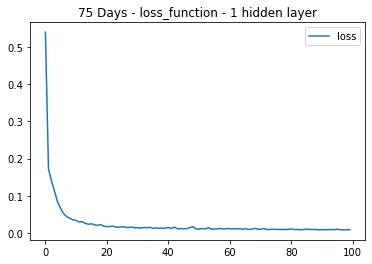

0.9913664260542974
0.9826742634956773


In [73]:
layers = { "number_input_features": 6,
      "n_layers": 4, 
      "l0":{"number_hidden_nodes":18,"activation_function":"relu"},
      "l1":{"number_hidden_nodes":9,"activation_function":"relu"},
      "l2":{"number_hidden_nodes":4,"activation_function":"relu"},
      "l3":{"number_hidden_nodes":1,"activation_function":"linear"}
          
     }

mc = ml()
mc.train_test(df=final_df,test_size=0.05,target="cases",**layers)
model_c = mc.getModel()

In [ ]:
final_df.to_csv("final_df.csv")